In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Estrid Buhl Naver (DTU), Maja Østergaard ( Aarhus University) and Silvio Achilles (DESY)
#   Edited by: Margaret Duff (STFC - UKRI), Jakob Sauer Jørgensen (DTU), Edo Pasca (STFC - UKRI)

# Cone-beam offset reconstruction

### Reconstruction of an apple measured with offset detector.

Apple measured with lab-Xray CT machine where the detector was offset in order to image the entire sample in the tomography.  We scanned the apple, which was too wide for the regular beam, in offset mode, where the fan only covers a bit more than half of the apple width, and due to offsetting the rotation centre to the side, the other half of the apple will rotate into the fan and as such full data will be recorded.   The default reconstruction done by the table top CT machine did not support this, so we used CIL to set up the offset geometry. This notebook showcases three different reconstructions of this sample, one using the filtered-back-projection and two using iterative methods.

### CIL Version 23.1.0

In [2]:
import cil
print(cil.__version__)

23.1.0


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.io import TIFFStackReader
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer, Padder
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry, show1D
from cil.framework import AcquisitionGeometry, ImageGeometry
from cil.utilities.jupyter import islicer

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA
from cil.optimisation.functions import IndicatorBox,  LeastSquares, TotalVariation, OperatorCompositionFunction,L2NormSquared
from cil.optimisation.operators import  GradientOperator
                                       
# Import from CIL ASTRA plugin
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator

## Setting up the geometry

We define the geometry of the system. 

In [4]:
# Define cone geometry variables
SOD = 355 # mm
SDD = 398 # mm
COR = -100 # number of pixels from the edge of the center
pixel_size = 0.048 # mm
image_pixel_size = 0.096 # mm

angles_arr = np.linspace(0, 2*np.pi, 200)

In [5]:
# create AcquisitionGeometry
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0.0, -SOD, 0.0],
    detector_position=[0, SDD-SOD, 0.0],
    rotation_axis_direction=[0., 0., 1.0]
)
ag.set_centre_of_rotation(-COR*pixel_size)
ag.set_angles(angles=angles_arr, angle_unit='radian' )
ag.set_panel(num_pixels=[500, 500], pixel_size=pixel_size, origin='top-left') 

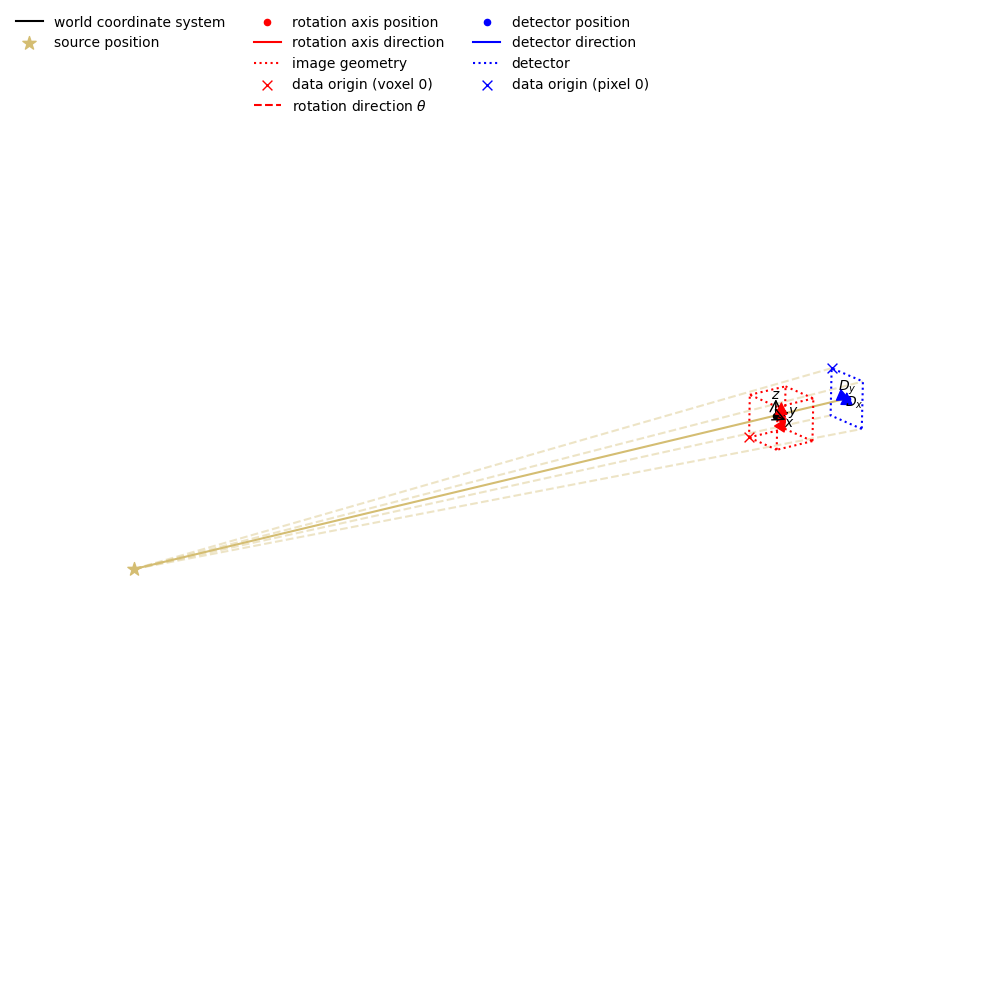

In [6]:
show_geometry(ag, view_distance=2)

## The dataset

This requires the dataset `apple.zip` from  https://doi.org/10.5281/zenodo.10089694.
Please download the data and update the 'proj_folder' variable below to point to where you have the projections saved:

In [7]:
proj_folder = './Apple_offset/raw/projections'
n_projs = 200  # and starts with idx 0
data = TIFFStackReader(file_name=proj_folder).read_as_AcquisitionData(ag)

Preprocess the data so it is ready for reconstruction.

In [8]:

data.array = data.array/np.max(data.array)
data = TransmissionAbsorptionConverter()(data)

Visualise the projections: 

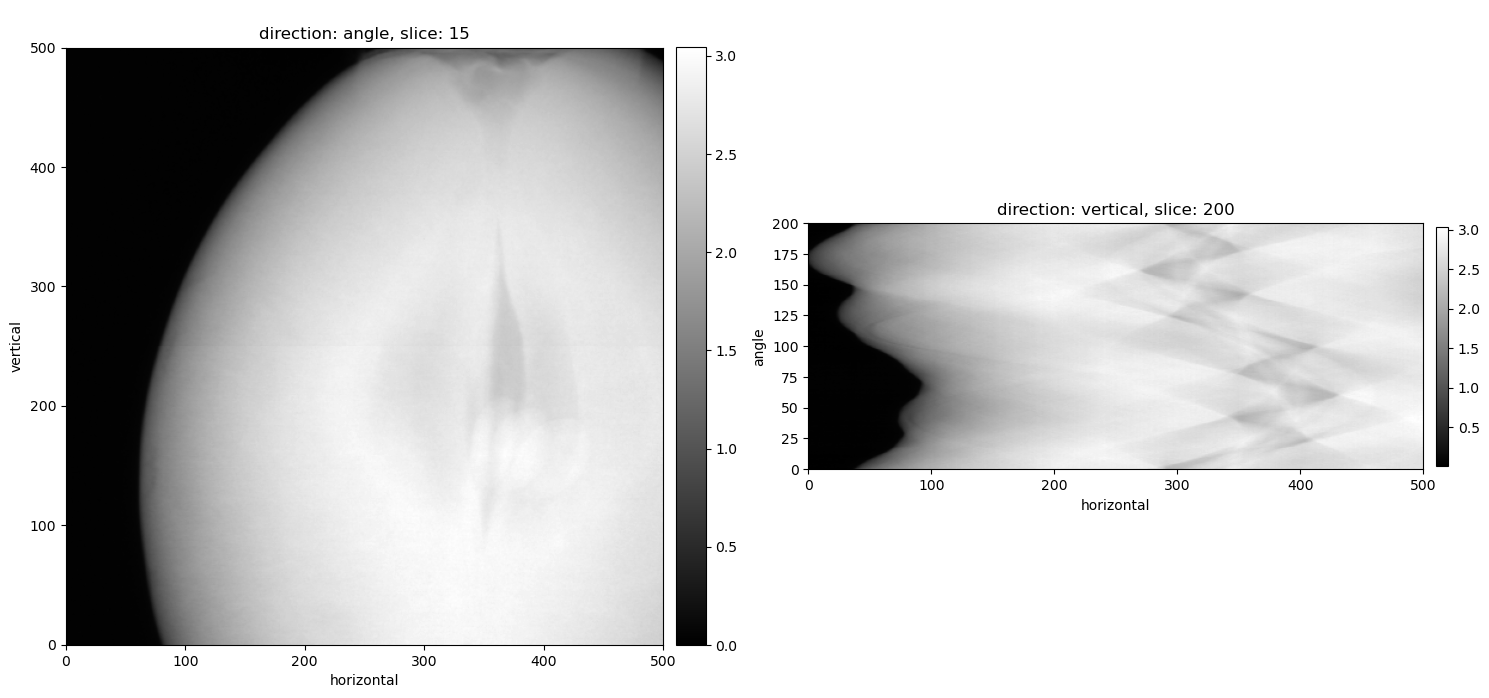

In [9]:
show2D(data, slice_list=[('angle',15), ('vertical', 200) ])


## Automatic reconstruction 

We load the scanner reconstruction for comparison 

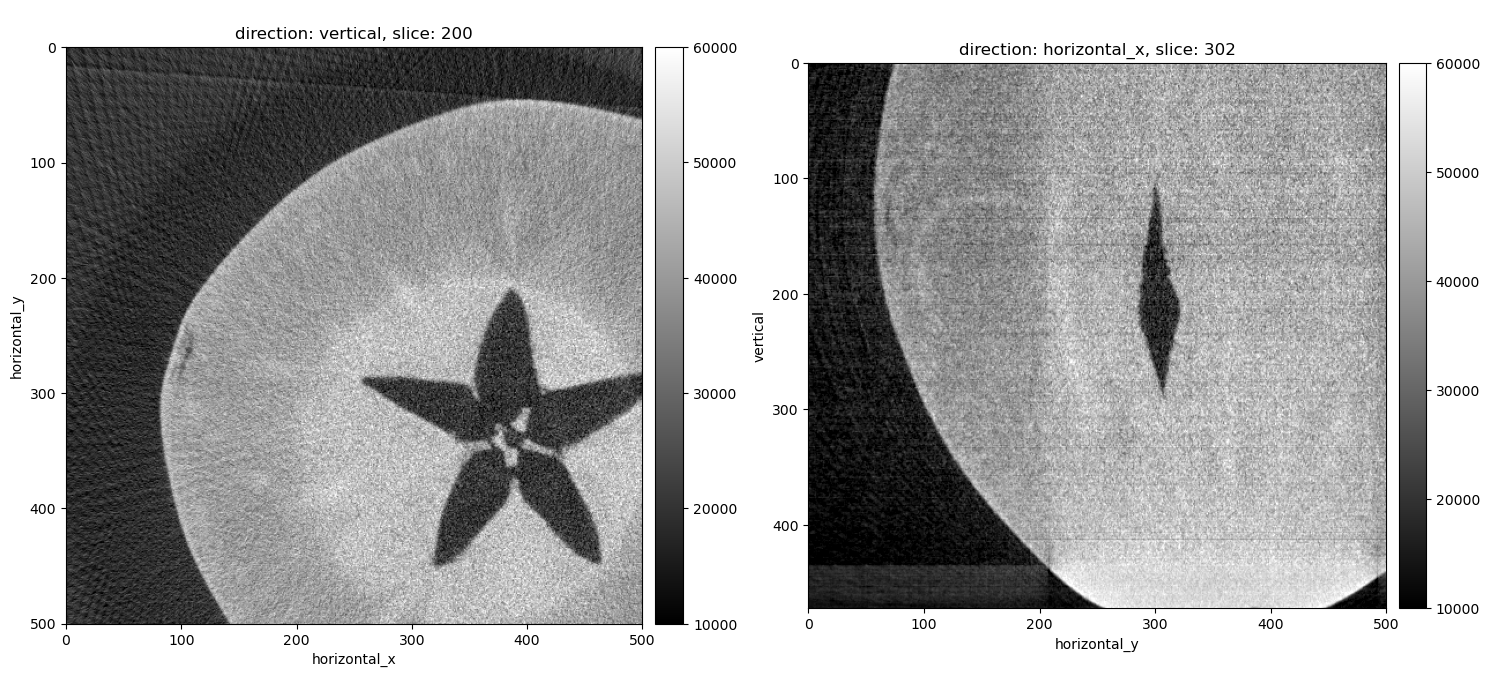

In [10]:
proj_folder = './Apple_offset/raw/reconstruction'
n_projs = 200  # and starts with idx 0
ig = ImageGeometry( 500, 500, 472) 
recon_scanner = TIFFStackReader(file_name=proj_folder).read_as_ImageData(ig )
show2D(recon_scanner, slice_list=[('vertical',200), ('horizontal_x', 302)], fix_range=(10000, 60000), origin='upper-left')

We see that the scanner is unable to reconstruct the full slice of the apple. There is also a brighter circle as part of the horizontal slice and a brighter vertical strip in the vertical slice.   This is because these areas are always within the field of view whereas the other parts of the apple move in and out the field of view.  The aim of this notebook is to do better! 

## FBP Reconstruction

We start by using the FBP reconstruction. 

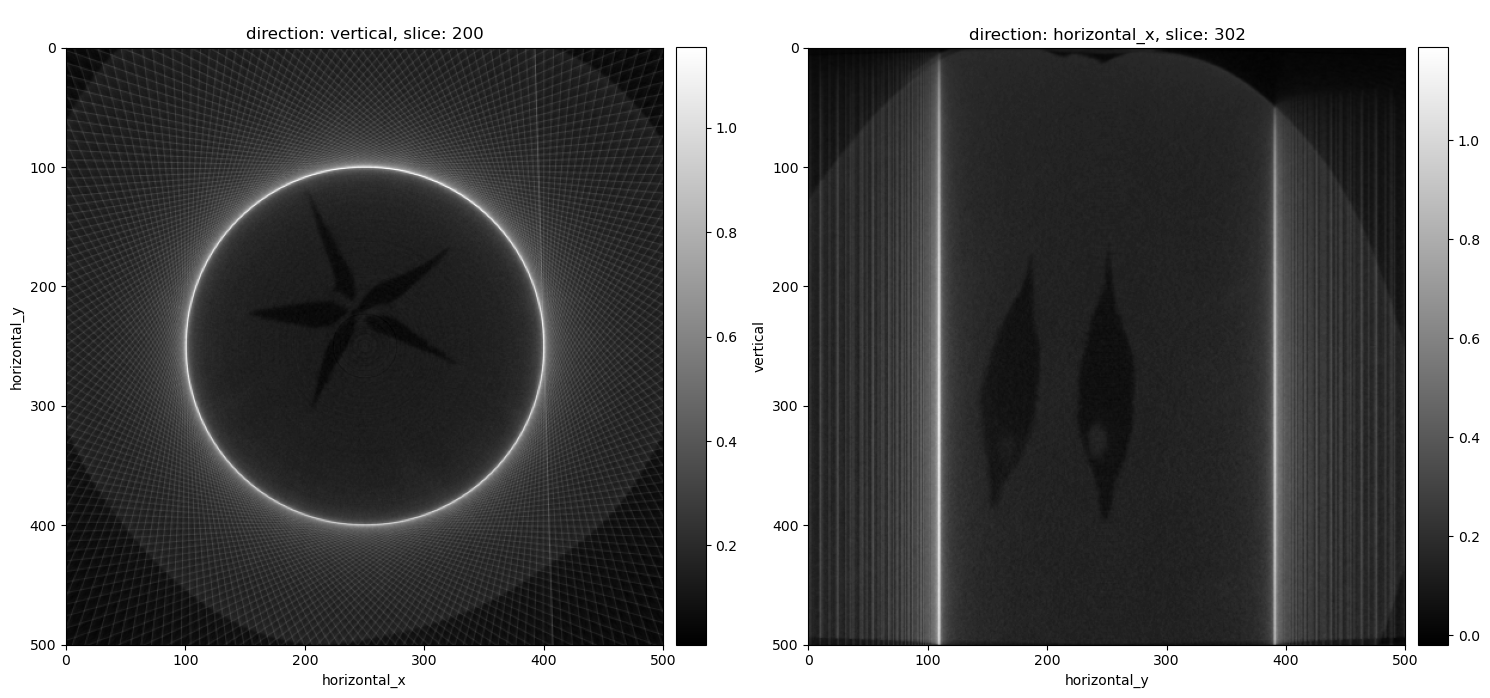

In [11]:
data.reorder(order='astra')
ig = data.geometry.get_ImageGeometry() 
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)

show2D(recon, slice_list=[('vertical',200), ('horizontal_x', 302)], origin='upper-left')

There is a very clear region-of-interest artifact so we choose to pad the projections to get it away from the sample.

In [12]:
# Padding the data
Npad = 300
data_padded = Padder.edge(pad_width={'horizontal':(Npad, Npad)})(data) # Padding in horizontal direction

In [13]:
ig = ImageGeometry(580, 580, 400, pixel_size, pixel_size, pixel_size) 


In [14]:
fbp =  FBP(ig, data_padded.geometry, "gpu")
recon = fbp(data_padded)

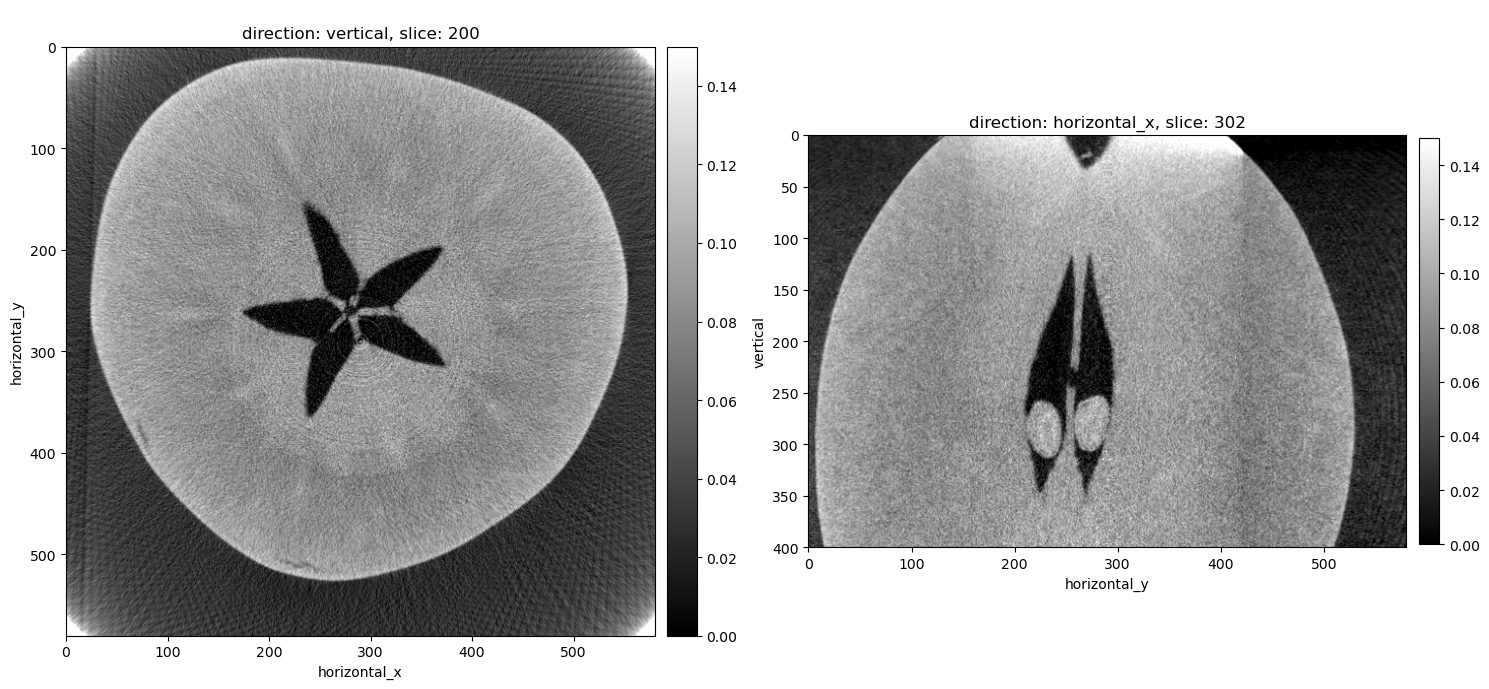

In [15]:
show2D(recon, slice_list=[('vertical',200), ('horizontal_x', 302)],fix_range=(0.0,0.15), origin='upper-left')

We can use the CIL centre of rotation corrector to check the centre of rotation inputted when we set up the geometry earlier.

In [16]:
from cil.processors import CentreOfRotationCorrector

processor = CentreOfRotationCorrector.image_sharpness(search_range=100, tolerance=0.1)
processor.set_input(data_padded)
data_centred = processor.get_output()
data_centred.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (0.14603414381488417, 'pixels'), 'angle': (0.0, 'radian')}

We see a very small update of 0.14 pixels on top of the 100 pixels we set earlier. We can update our COR with this value but it makes very little difference to our reconstructed image:

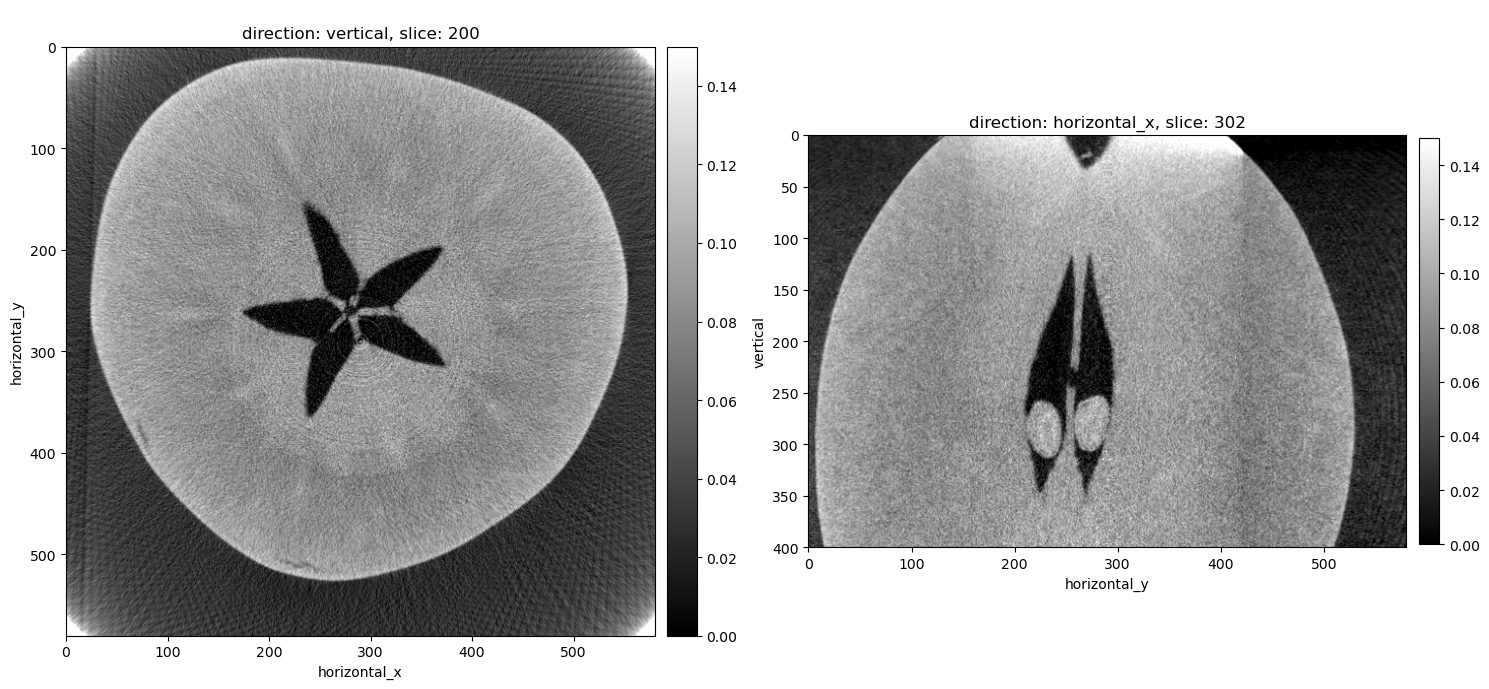

In [17]:
ag.set_centre_of_rotation(-COR*pixel_size+data_centred.geometry.get_centre_of_rotation()['offset'][0]*pixel_size)
fbp =  FBP(ig, data_padded.geometry, "gpu")
recon = fbp(data_padded)
show2D(recon, slice_list=[('vertical',200), ('horizontal_x', 302)], fix_range=(0.0,0.15), origin='upper-left')


Adjusting the contrast we can see there still remains a bright circular artifact in the horizontal slice and a stripe pattern in the vertical slice.

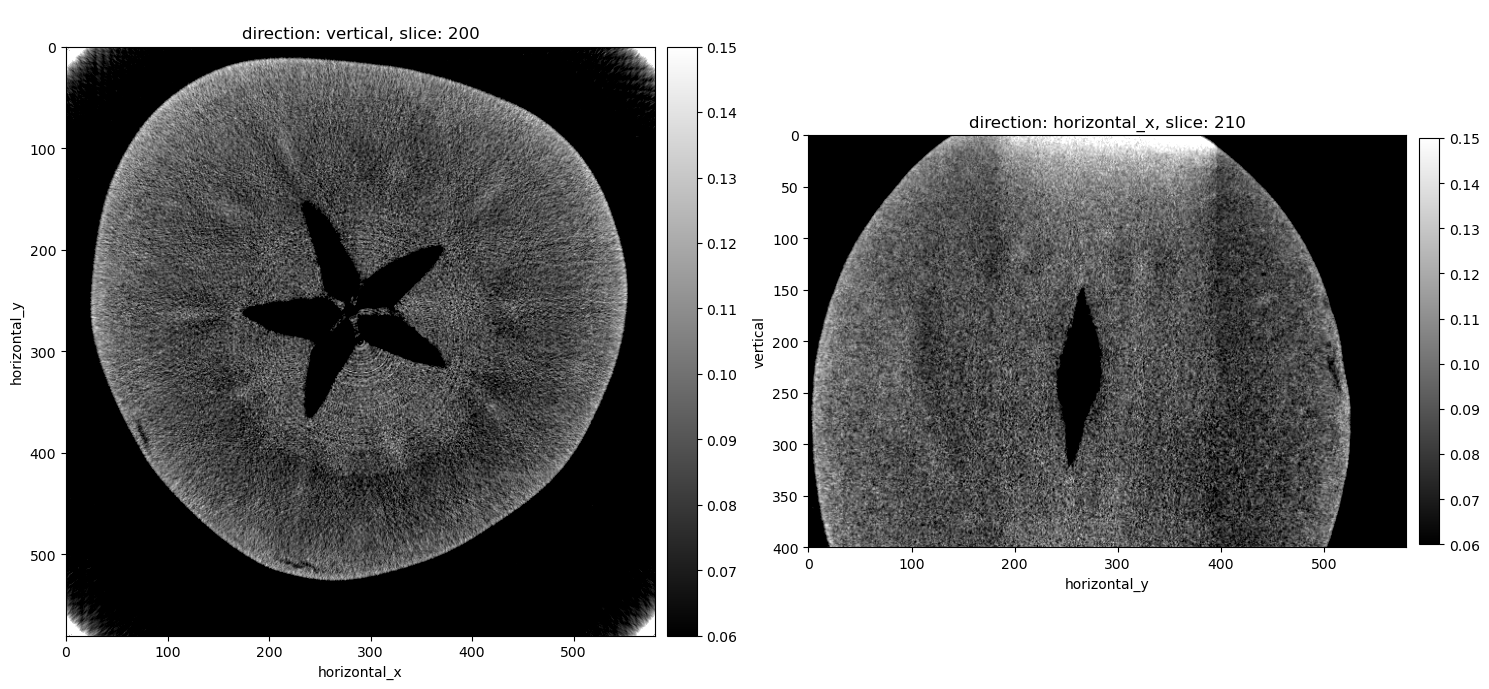

In [18]:
show2D(recon, slice_list=[('vertical',200), ('horizontal_x', 210)], fix_range=(0.06,0.15), origin='upper-left')

This can also be viewed on a line plot where we see a hump in the middle of the apple slice. We take multiple horizontal lines in the horizontal slice, visualised in a thick red band, plot their line profiles and also plot an average line profile for this section of the slice. Multiple lines and an average are useful to visualise the underlying behaviour amoungst the noise. 

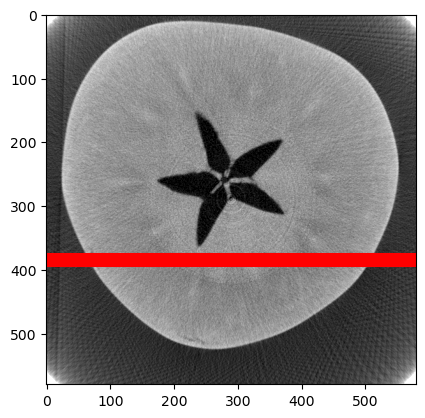

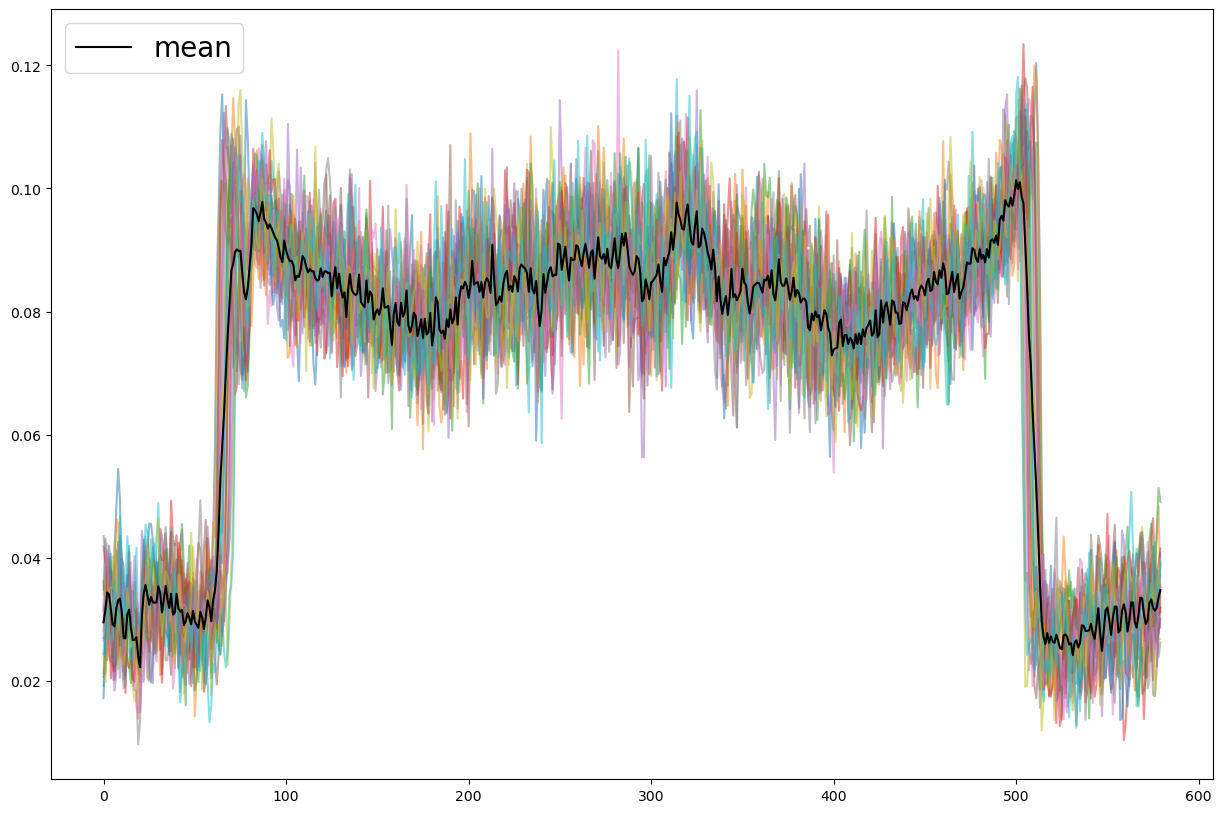

In [19]:
#Visualise the results using a line plot
plt.figure()
plt.imshow(recon.get_slice(vertical='centre').as_array(), cmap='gray', vmin=0, vmax=0.15 )
for i in range(20):
    plt.plot(range(580), (375+i)*np.ones(580), 'red')
plt.show()
                          
                          
linenumy=200
plt.figure(figsize=(15,10))
for i in range(20):
    if i==0:
        total=recon.get_slice(vertical='centre', horizontal_y=375+i).as_array()
    else:
        total+=recon.get_slice(vertical='centre', horizontal_y=375+i).as_array()
    plt.plot(recon.get_slice(vertical='centre', horizontal_y=375+i).as_array(), alpha=0.5)
plt.plot(total/20, label='mean', color='black')
plt.legend(fontsize=20)
plt.show()

The hope is that using iterative reconstruction, where the projector can take into account the repeated measurements of some areas will lead to a reconstruction without these artifacts. 

## Iterative reconstruction

We run iterative reconstruction on just the centre slice to speed up the reconstruction. It could be done on the whole 3D volume but it will be slow. We extend the image geometry but do not pad the data. 

In [20]:
data.reorder(order='astra') # Change the order of the variables in the array
data2D=data.get_slice(vertical='centre')
ag2D = data2D.geometry
ig = ImageGeometry(580, 580,400 , pixel_size, pixel_size, pixel_size)  
ig2D=ig.get_slice(vertical='centre')
# Set up linear operator representing forward and backward projections
A = ProjectionOperator(ig2D, ag2D, device="gpu")

Reconstruct using the gradient descent algorithm for a least squares objective without regularisation.

In [21]:
f1 = LeastSquares(A, data2D)# Set up least squares problem
D = GradientOperator(ig2D)
f2 = OperatorCompositionFunction(L2NormSquared(),D)
alpha=0.0
f = f1 + (alpha**2)*f2

x0 = ig2D.allocate(0.0) # Start from image no. 0

# Set up gradient descent algorithm
myGD_LS = GD(initial=x0, 
             objective_function=f, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=100)

In the first few iterations, the bright circle is still clearly visible :

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          5.43500e+05


-------------------------------------------------------
        5       1000         0.114                     
Stop criterion has been reached.



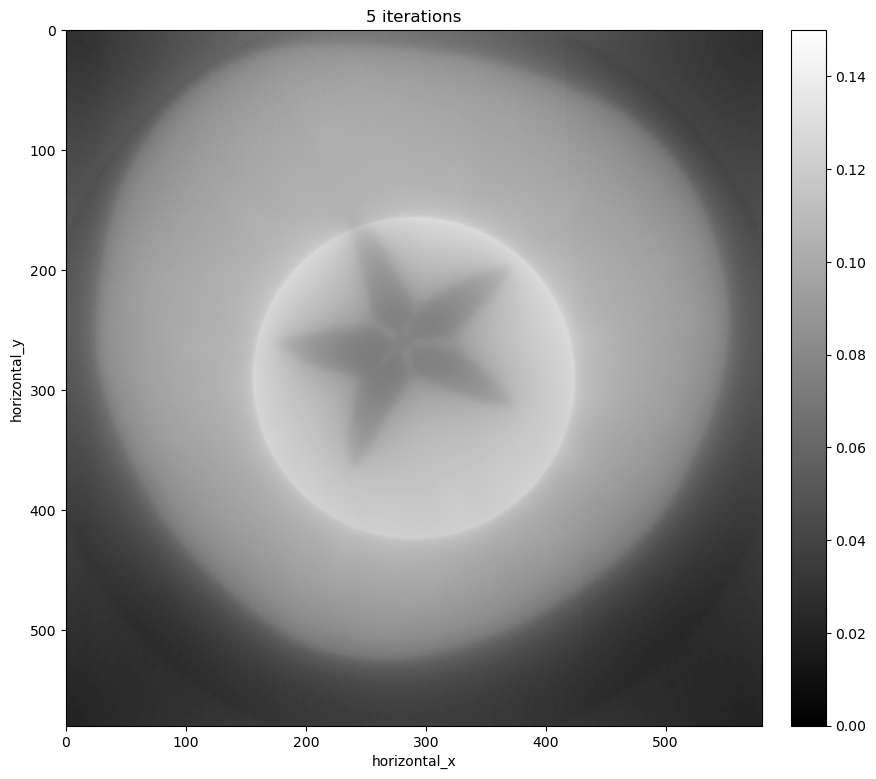

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        5       1000         0.114                     
-------------------------------------------------------
       30       1000         0.056                     
Stop criterion has been reached.



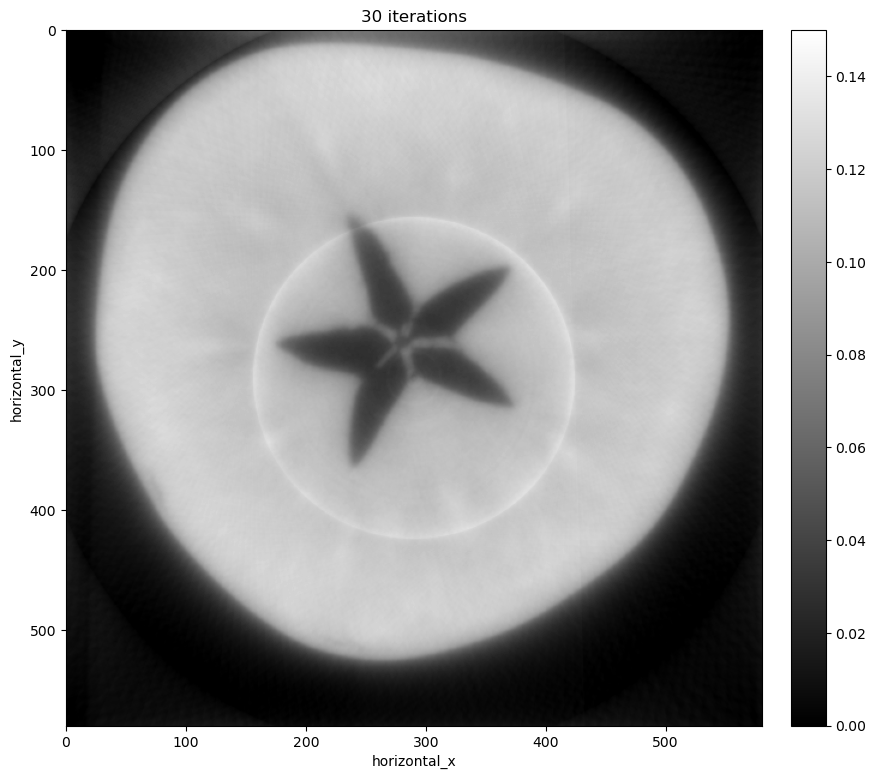

In [22]:

myGD_LS.run(5, verbose=1) # run gradient descent algorithm
show2D(myGD_LS.solution, fix_range=(0.0,0.15), title='5 iterations', origin='upper-left')


myGD_LS.run(25, verbose=1) # run gradient descent algorithm
show2D(myGD_LS.solution, fix_range=(0.0,0.15), title='30 iterations', origin='upper-left')

    

Running to convergence, we see the bright circle disappear but the ring artefact remains due to the truncated projection.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       30       1000         0.056                     


      100       1000         0.048          1.79873e+02
      200       1000         0.046          1.41060e+02
      300       1000         0.045          1.33630e+02
      400       1000         0.045          1.30990e+02
      500       1000         0.045          1.29754e+02
      600       1000         0.045          1.29071e+02
      700       1000         0.045          1.28645e+02
      800       1000         0.045          1.28353e+02
      900       1000         0.045          1.28139e+02
-------------------------------------------------------
      995       1000         0.045                     
Stop criterion has been reached.



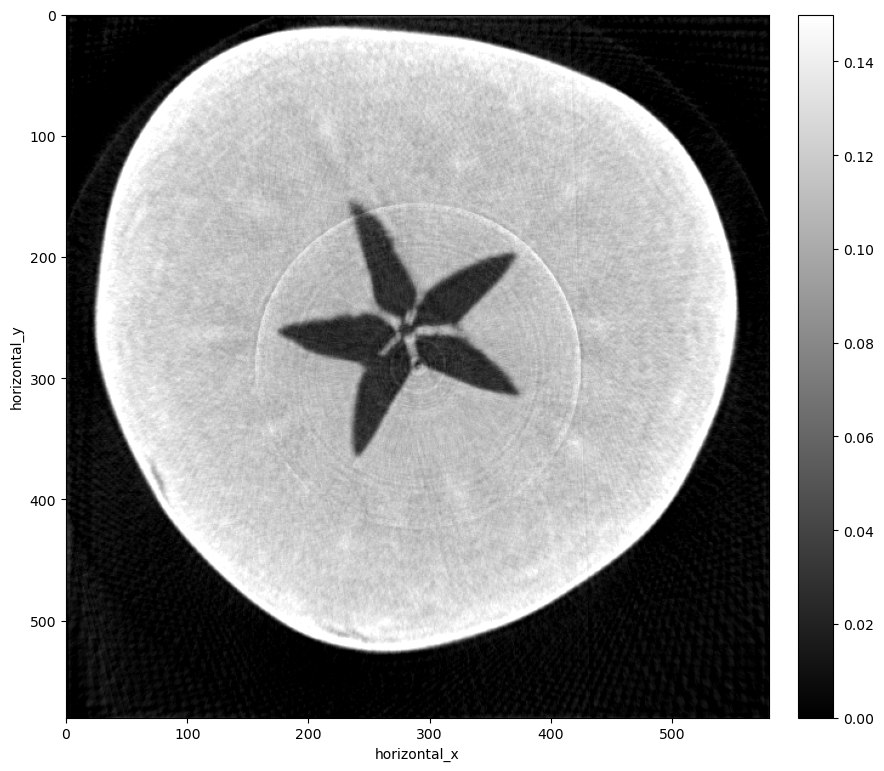

In [23]:
myGD_LS.run(965, verbose=1) # run gradient descent algorithm
show2D(myGD_LS.solution, fix_range=(0.0,0.15), origin='upper-left')

Again, we can visualise in a line plot. 

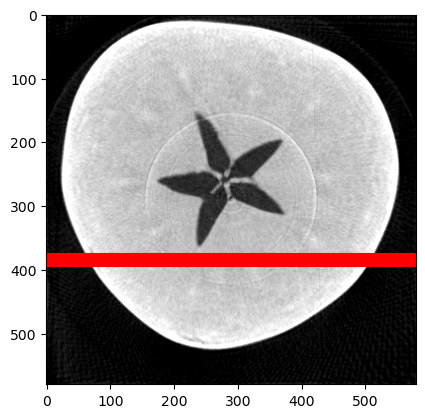

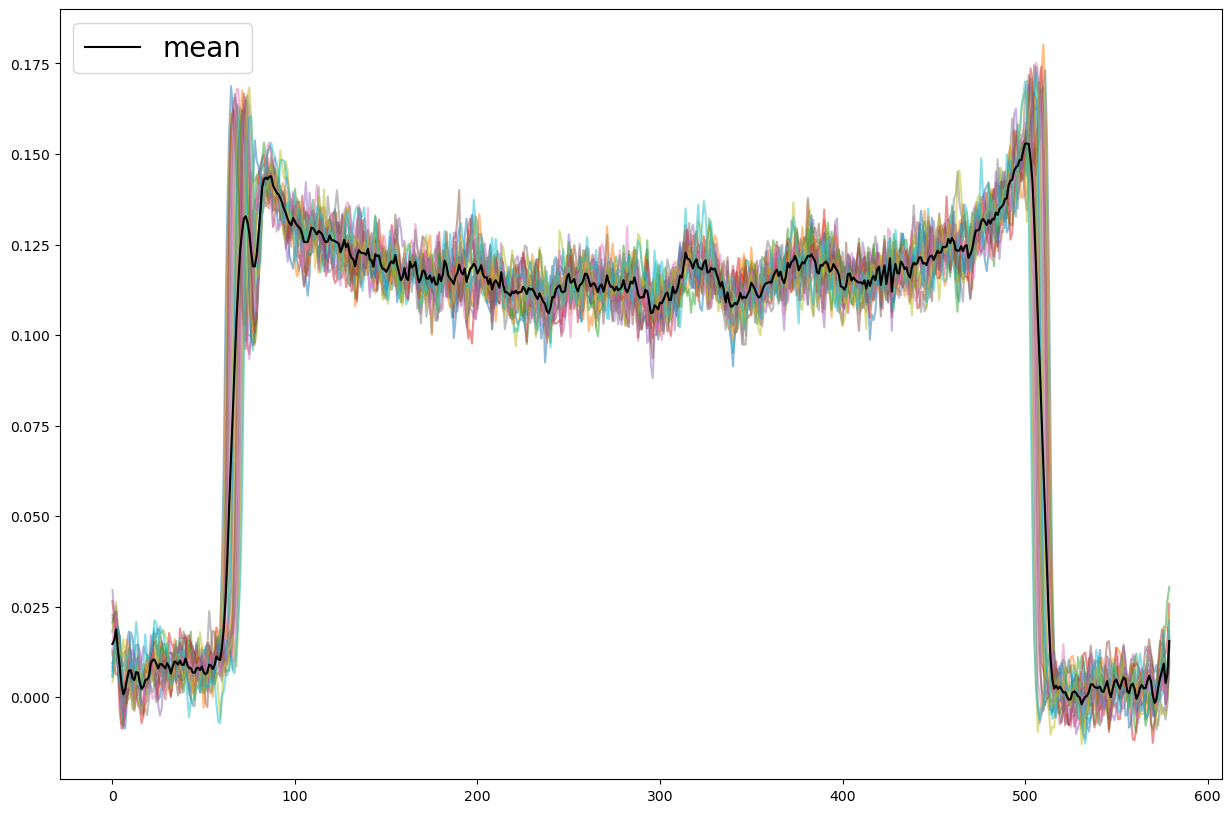

In [24]:
#Visualise the results using a line plot
plt.figure()
plt.imshow(myGD_LS.solution.as_array(), cmap='gray', vmin=0, vmax=0.15)
for i in range(20):
    plt.plot(range(580), (375+i)*np.ones(580), 'red')
plt.show()
                          
                          
linenumy=200
plt.figure(figsize=(15,10))
for i in range(20):
    if i==0:
        total=myGD_LS.solution.get_slice( horizontal_y=375+i).as_array()
    else:
        total+=myGD_LS.solution.get_slice( horizontal_y=375+i).as_array()
    plt.plot(myGD_LS.solution.get_slice( horizontal_y=375+i).as_array(), alpha=0.5)
plt.plot(total/20, label='mean', color='black')
plt.legend(fontsize=20)
plt.show()

We can also try reconstruction using Tikhonov regularisation to smooth out the ring artefacts. It succeeds with all but the largest one, caused by the padding. 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          5.43500e+05


      100       1000         0.048          2.20849e+02
      200       1000         0.047          1.96799e+02
      300       1000         0.046          1.94713e+02
      400       1000         0.046          1.94320e+02
      500       1000         0.046          1.94184e+02
-------------------------------------------------------
      500       1000         0.046          1.94184e+02
Stop criterion has been reached.



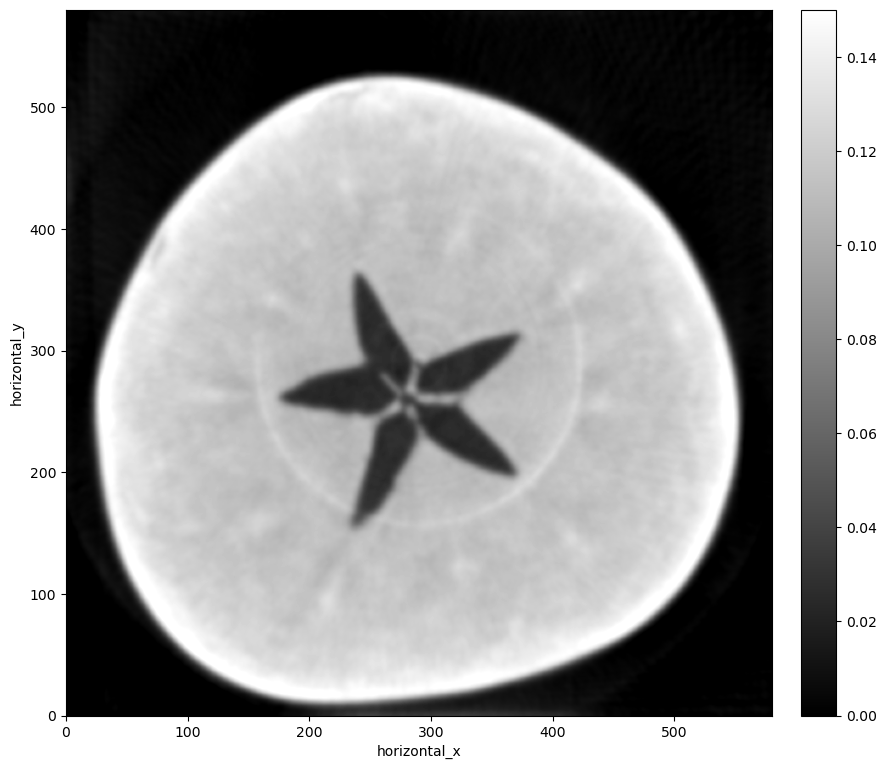

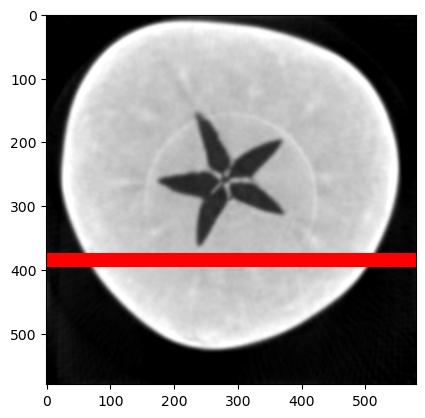

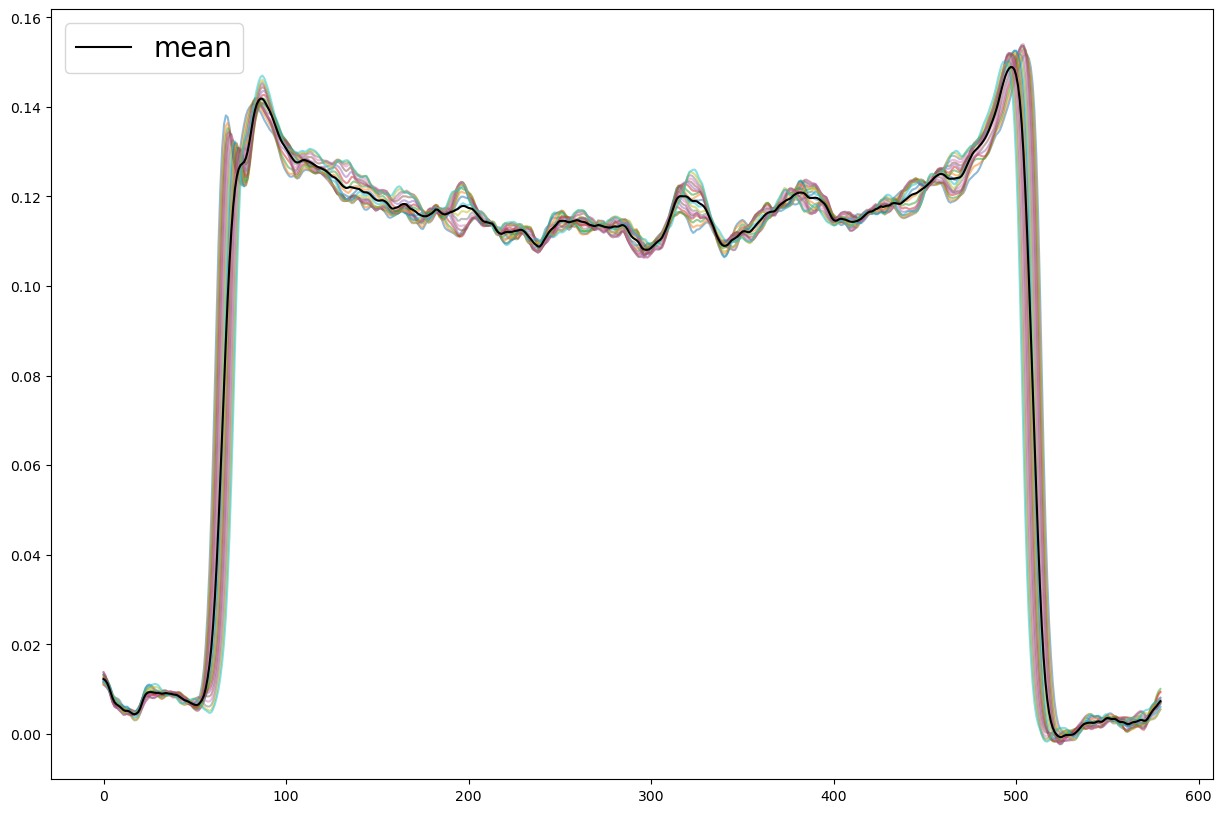

In [25]:
f1 = LeastSquares(A, data2D)# Set up least squares problem
D = GradientOperator(ig2D)
f2 = OperatorCompositionFunction(L2NormSquared(),D)
alpha=0.15
f = f1 + (alpha**2)*f2

x0 = ig2D.allocate(0.0) # Start from image no. 0

# Set up gradient descent algorithm
myGD_LS_TIK = GD(initial=x0, 
             objective_function=f, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=100)
myGD_LS_TIK.run(500, verbose=1) # run gradient descent algorithm
show2D(myGD_LS_TIK.solution, fix_range=(0.0,0.15))

#Visualise the results using a line plot
plt.figure()
plt.imshow(myGD_LS_TIK.solution.as_array(), cmap='gray', vmin=0, vmax=0.15)
for i in range(20):
    plt.plot(range(580), (375+i)*np.ones(580), 'red')
plt.show()
                          
                          
linenumy=200
plt.figure(figsize=(15,10))
for i in range(20):
    if i==0:
        total=myGD_LS_TIK.solution.get_slice( horizontal_y=375+i).as_array()
    else:
        total+=myGD_LS_TIK.solution.get_slice( horizontal_y=375+i).as_array()
    plt.plot(myGD_LS_TIK.solution.get_slice( horizontal_y=375+i).as_array(), alpha=0.5)
plt.plot(total/20, label='mean', color='black')
plt.legend(fontsize=20)
plt.show()

The Tikhonov regularisation also smooths out the rest of the image, not just the rings, as can be seen in the image and the line plot. Other options  could be explored for further removal of the rings such as: fine-tuning alignment, stitching projections, padding or the CIL RingRemover! Also note that the CIL FBP recon also shows ring artefacts.  We also note that the U-shaped line profile of the apple is characteristic of beam hardening effects and further work could be done to correct for this. 